In this example, we will solve a 2D Ising Model on a square lattice. The Hamiltonian for this system is 

$$ H = \dfrac{1}{2}\sum_{i,j}^{NN}V_1 \sigma_i\sigma_j + \dfrac{1}{2}\sum_{i,j}^{NNN}V_2\sigma_i\sigma_j - \mu\sum_{i}\sigma_i$$
with $\sigma_i = \pm 1$ where we have included interactions between nearest-neighbor and next-nearest-neighbor interactions, characterized by $V_1$ and $V_2$, respectively. The chemical potential (specifically, the difference in potential between up and down spins) $\mu$ controls the energetic dependence on composition - in Ising parlance, this is the external magnetic field. Note that $V < 0$ denotes a ferromagnetic interaction whie $V > 0$ is antiferromagnetic. Define $\sigma$ as a particular microstate of the system (configuration of the spins) and $\{\sigma\}$ as the collection of all possible microstates of the system. Average quantities for the system are evaluated using the partition function 

$$Z = \sum_{\{\sigma\}} \exp(-\beta H(\sigma))$$
$$\langle A \rangle = \sum_{\{\sigma\}} P(\sigma)A(\sigma) = \dfrac{1}{Z}\sum_{\{\sigma\}}\exp(-\beta H(\sigma))A(\sigma)\Rightarrow \dfrac{1}{N_{MC}}\sum_{\{\sigma\}_{MC}}A(\sigma)_{MC}$$

Monte Carlo techniques are based on replacing this weighted sum over all simply-sampled configurations into a direct average of importance-sampled configurations $\{\sigma\}_{MC}$ using the Metropolis-Hastings acceptance scheme. By this algorithm, we are able to visit each microstate $\sigma$ with the correct thermal probabilty $P(\sigma)$, therefore eliminating the need to directly evaluate the partition function. 

This model is solved on an $L_x \times L_y$ lattice of binary spins with periodic boundary conditions applied in both directions. Macroscopic averages in this model are computed via grand-canonical Monte Carlo using the Metropolis-Hastings algorithm, described below: 

(1) Attempt to flip each spin by sweeping through the lattice once - this is defined as on Monte Carlo step

(2) For each spin flip $(i,j)$, calculate $\Delta E = E(-\sigma_{ij}) - E_(\sigma_{ij})$ according to the formula for the Hamiltonian

(3) If $\Delta E \leq 0$, accept the spin flip $\sigma_{ij}\rightarrow -\sigma_{ij}$. If $\Delta E > 0$, compare a randomly generated number $R \in (0, 1)$ to $p = e^{\frac{-\Delta E}{k_BT}}$; if $R \leq p$, accept the flip, otherwise reject it.

(4) Record the values of energy $E$, magnetization $M$, $E^2$, and $M^2$ for each MC step

This procedure must be performed on a randomly-generated lattice for given number of steps to bring the system to equilibrium (values need not be recorded during these steps) and then measurements are performed/values are recorded for a subsequent number of Monte Carlo steps and averaged to produce $\langle E \rangle$, $\langle M \rangle$, $\langle E^2 \rangle$, and $\langle M^2 \rangle$. Note that the magnetization in Ising models is simply the sum of the spins on the lattice $\sum_i \sigma_i$. The heat capacity and susceptibility (and any other second derivative of energy) can be calculated using relations derived from the partition function. In particular,

$$C_V = \dfrac{\langle E^2\rangle - \langle E\rangle^2}{k_BT^2}$$

$$\chi_M = \dfrac{\langle M^2\rangle - \langle M \rangle^2}{k_BT}$$

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

# Lessons learned:
# Python array indexing A[a:b] pulls out A[a]...A[b-1] -> not including index b!
# Pulling out indices needs .astype(int) to reference in another matrix... this doesn't seem to be right though 
# Initialize each vector to np.zeros() individually. Don't do it in one line and don't set a = np.zeros(5); b = a, etc. to get multiple vectors set to zeros

In [3]:
# Basic function definitions

def initializeLattice(Ly,Lx,frac):
    # Random composition for grand-canonical simulation - requires spin-flipping (Glauber) dynamics
    if frac == 0: 
        LAT = 2*np.random.randint(2, size=(Ly,Lx))-1
    # Fixed composition lattice for canonical simulation - requires spin-conservative (Kawasaki) dynamics     
    else: 
        LAT = np.ones([Ly,Lx])
        N = np.ceil(frac*Ly*Lx)
        R = np.random.randint(Lx*Ly,size=(int(1),int(N)))
        ind = np.unravel_index(R,(Ly,Lx))
        LAT[ind[0],ind[1]] = -1
    return LAT
    
def neighborList(LAT,geo):
    a = LAT.shape
    Lx = a[1]; Ly = a[0];
    
    # Square lattice - NN and NNN 
    if geo == 0: 
        NLIST = np.zeros([Lx,Ly,2,8])
        for i in range(Ly):
            for j in range(Lx):  
                if i > 0 and i < Ly-1:
                    up_row = i-1; down_row = i+1; lft_row = i; rt_row = i;
                    uprt_row = i-1; uplft_row = i-1; dwnlft_row = i+1; dwnrt_row = i+1;
                elif i == 0:
                    up_row = Ly-1; down_row = i+1; lft_row = i; rt_row = i;
                    uprt_row = Ly-1; uplft_row = Ly-1; dwnlft_row = i+1; dwnrt_row = i+1;
                else:
                    up_row = i-1; down_row = 0; lft_row = i; rt_row = i;
                    uprt_row = i-1; uplft_row = i-1; dwnlft_row = 0; dwnrt_row = 0;          
                if j > 0 and j < Lx-1:
                    up_col = j; down_col = j; lft_col = j-1; rt_col = j+1;
                    uprt_col = j+1; uplft_col = j-1; dwnlft_col = j-1; dwnrt_col = j+1;
                elif j == 0:
                    up_col = j; down_col = j; lft_col = Lx-1; rt_col = j+1;
                    uprt_col = j+1; uplft_col = Lx-1; dwnlft_col = Lx-1; dwnrt_col = j+1;
                else:
                    up_col = j; down_col = j; lft_col = j-1; rt_col = 0;
                    uprt_col = 0; uplft_col = j-1; dwnlft_col = j-1; dwnrt_col = 0;
                
                ROW = [up_row, down_row, lft_row, rt_row, uprt_row, uplft_row, dwnlft_row, dwnrt_row]  
                COL = [up_col, down_col, lft_col, rt_col, uprt_col, uplft_col, dwnlft_col, dwnrt_col]
                NLIST[i,j,0,:] = ROW
                NLIST[i,j,1,:] = COL      
        return NLIST
    
    # Triangular lattice - NN
    if geo == 1: 
        NLIST = np.zeros([Lx,Ly,2,6])
        for i in range(Ly):
            for j in range(Lx):  
                if i > 0 and i < Ly-1:
                    up_row = i-1; down_row = i+1; lft_row = i; rt_row = i; diag_dwn_row = i+1; diag_up_row = i-1;
                elif i == 0:
                    up_row = Ly-1; down_row = i+1; lft_row = i; rt_row = i; diag_dwn_row = i+1; diag_up_row = Ly-1;
                else:
                    up_row = i-1; down_row = 0; lft_row = i; rt_row = i; diag_dwn_row = 0; diag_up_row = i-1;       
                if j > 0 and j < Lx-1:
                    up_col = j; down_col = j; lft_col = j-1; rt_col = j+1; diag_dwn_col = j+1; diag_up_col = j-1;
                elif j == 0:
                    up_col = j; down_col = j; lft_col = Lx-1; rt_col = j+1; diag_dwn_col = j+1; diag_up_col = Lx-1;
                else:
                    up_col = j; down_col = j; lft_col = j-1; rt_col = 0; diag_dwn_col = 0; diag_up_col = j-1;
                
                ROW = [up_row, down_row, lft_row, rt_row, diag_dwn_row, diag_up_row]  
                COL = [up_col, down_col, lft_col, rt_col, diag_dwn_col, diag_up_col]
                NLIST[i,j,0,:] = ROW
                NLIST[i,j,1,:] = COL      
        return NLIST

def calcTotEnergy(LAT,NLIST,V,mu,geo):
    V1 = V[0]; V2 = V[1];
    a = LAT.shape; Ly = a[0];  Lx = a[1];
    
    # Square lattice
    if geo == 0:
        E = 0
        for i in range(Ly):
            for j in range(Lx):
                NNr = NLIST[i,j,0,0:4].astype(int)
                NNc = NLIST[i,j,1,0:4].astype(int)
                NNNr = NLIST[i,j,0,4:8].astype(int)
                NNNc = NLIST[i,j,1,4:8].astype(int)
                E = E + V1/2*np.sum( LAT[i,j]*LAT[NNr,NNc] ) + V2/2*np.sum( LAT[i,j]*LAT[NNNr,NNNc] ) - mu*LAT[i,j]
        return E  
    # Triangular Lattice
    if geo == 1:
        E = 0
        for i in range(Ly):
            for j in range(Lx):
                NNr = NLIST[i,j,0,:].astype(int)
                NNc = NLIST[i,j,1,:].astype(int)
                E = E + V1/2*np.sum( LAT[i,j]*LAT[NNr,NNc] ) - mu*LAT[i,j]
        return E

def calcdE(LAT,NLIST,V,mu,flip,geo):
    V1 = V[0]; V2 = V[1];
    i = int(flip[0])
    j = int(flip[1])
    
    # Square lattice
    if geo == 0:
        NNr = NLIST[i,j,0,0:4].astype(int)
        NNc = NLIST[i,j,1,0:4].astype(int)
        NNNr = NLIST[i,j,0,4:8].astype(int)
        NNNc = NLIST[i,j,1,4:8].astype(int)
        e = V1*np.sum( LAT[i,j]*LAT[NNr,NNc] ) + V2*np.sum( LAT[i,j]*LAT[NNNr,NNNc] ) - mu*LAT[i,j]
        dE = -2*e
        return dE
    # Triangular lattice
    if geo == 1:
        NNr = NLIST[i,j,0,:].astype(int)
        NNc = NLIST[i,j,1,:].astype(int)
        e = V1*np.sum( LAT[i,j]*LAT[NNr,NNc] ) - mu*LAT[i,j]
        dE = -2*e
        return dE
    
def metropolisAccept(dE,T):
    if dE <= 0:
        return 1
    else:
        p = np.exp(-dE/T)
        r = np.random.random()
        if r <= p:
            return 1
        else:
            return 0

def MCsweep(LAT,NLIST,V,mu,T,E,M,geo):
    a = LAT.shape;  Ly = a[0];  Lx = a[1];
    for i in range(Ly):
        for j in range(Lx):
            flip = np.array([i,j])
            dE = calcdE(LAT,NLIST,V,mu,flip,geo)
            dM = -2*LAT[i,j]
            acc = metropolisAccept(dE,T)
            if acc == 1:
                E = E + dE
                M = M + dM
                LAT[i,j] = -LAT[i,j]
    return E, M, LAT
                
    

In [8]:
# 2D Ising Model Simulation

geo = 0
V1 = 1                      # NN interaction
V2 = -2                     # NNN interaction
V = np.array([V1,V2])       
mu = np.linspace(-4.5,4.5,70)   # Chemical potential/external field [/V1]
T = np.linspace(3,8.5,20)     # Temperature [/V1]]
Lx = 15;  Ly = 15;          # Lattice size Ly x Lx
Nsites = Lx*Ly;             # Number of lattice sites

eqsteps = int(1e3)          # Number of steps for equilibration
mcsteps = int(1e3)          # Number of MC steps to perform thermal averages

# Normalization factors
n1 = 1.0/(mcsteps*Nsites); n2 = 1.0/(mcsteps*mcsteps*Nsites)

# Initialize vectors of thermal averages
E1 = np.zeros([len(T),len(mu)])
M1 = np.zeros([len(T),len(mu)])
E2 = np.zeros([len(T),len(mu)])
M2 = np.zeros([len(T),len(mu)])
# Initialize nested list to store lattice configuration
#IM = [[0 for i in range(len(mu))] for j in range(len(mu))]

LAT = initializeLattice(Ly,Lx,0)
NLIST = neighborList(LAT,geo)

# Loop over temperatures
for tt in range(len(T)):
    # Loop over chemical potentials
    for uu in range(len(mu)):
    
        enn = enn2 = mag = mag2 = 0 
        LAT = initializeLattice(Ly,Lx,0)
        E = calcTotEnergy(LAT,NLIST,V,mu[uu],geo) 
        M = np.sum(np.sum(LAT))
        # Equilibration
        for i in range(eqsteps):
            E, M, LAT = MCsweep(LAT,NLIST,V,mu[uu],T[tt],E,M,geo)
        # Measurement
        for j in range(mcsteps):
            E, M, LAT = MCsweep(LAT,NLIST,V,mu[uu],T[tt],E,M,geo)
            # Accumulate lattice values per site
            enn = enn + E
            mag = mag + M
            enn2 = enn2 + E**2
            mag2 = mag2 + M**2    
        # Compute thermal averages by averaging over MC steps   
        E1[tt,uu]  = enn; E2[tt,uu] = enn2; M1[tt,uu] = mag; M2[tt,uu] = mag2;
        #IM[tt][uu] = LAT;

# Compute final normalized quantities
Energy = n1*E1
Mag = n1*M1
Cv = np.zeros([len(T),len(mu)])
ChiX = np.zeros([len(T),len(mu)])
for i in range(len(mu)):    
    Cv[:,i] = (n1*E2[:,i] - n2*E1[:,i]**2)/T**2
    ChiX[:,i] = (n1*M2[:,i] - n2*M1[:,i]**2)/T 

    

Text(0.5,0.98,'Square Lattice')

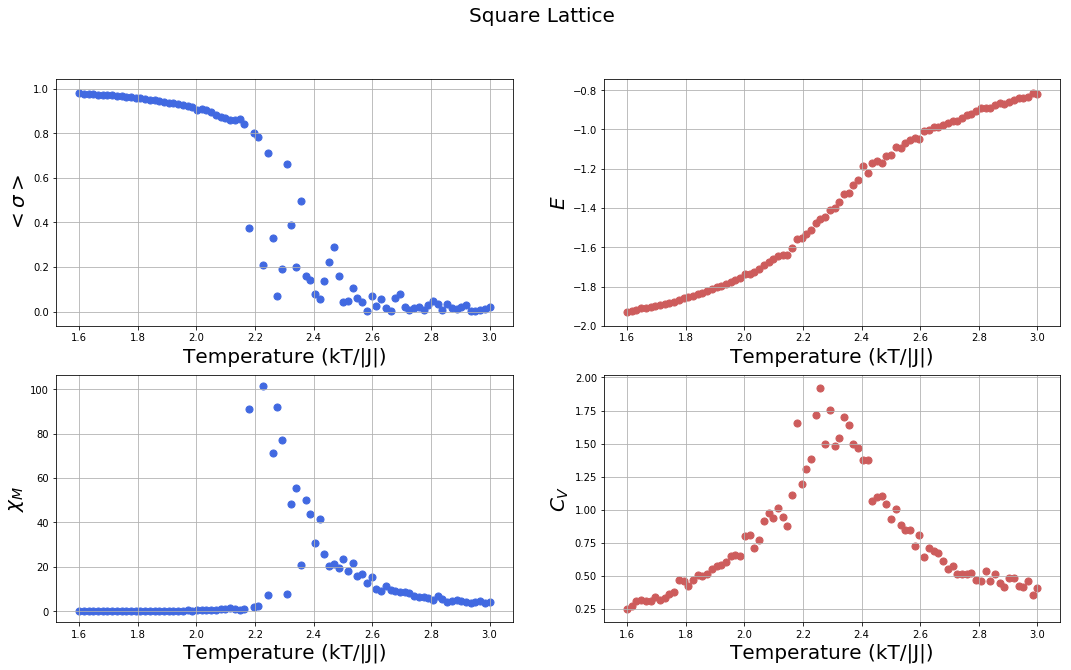

In [5]:
# Square Lattice
f = plt.figure(figsize=(18, 10));   
    
sp = f.add_subplot(2,2,1);
plt.scatter(T, abs(Mag[:,0]), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (kT/|J|)", fontsize=20); 
plt.ylabel(r'$<\sigma>$', fontsize=20); 
plt.axis('tight'); plt.grid(True);
    
sp = f.add_subplot(2,2,2);
plt.scatter(T, Energy[:,0], s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (kT/|J|)", fontsize=20); 
plt.ylabel(r'$E$', fontsize=20); 
plt.axis('tight'); plt.grid(True);
    
sp = f.add_subplot(2,2,4);
plt.scatter(T, Cv[:,0], s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (kT/|J|)", fontsize=20); 
plt.ylabel(r'$C_V$', fontsize=20); 
plt.axis('tight'); plt.grid(True);
    
sp = f.add_subplot(2,2,3);
plt.scatter(T, ChiX[:,0], s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (kT/|J|)", fontsize=20); 
plt.ylabel(r'$\chi_M$', fontsize=20); 
plt.axis('tight'); plt.grid(True);
    
f.suptitle('Square Lattice',fontsize=20)

Text(0.5,0.98,'Triangular Lattice')

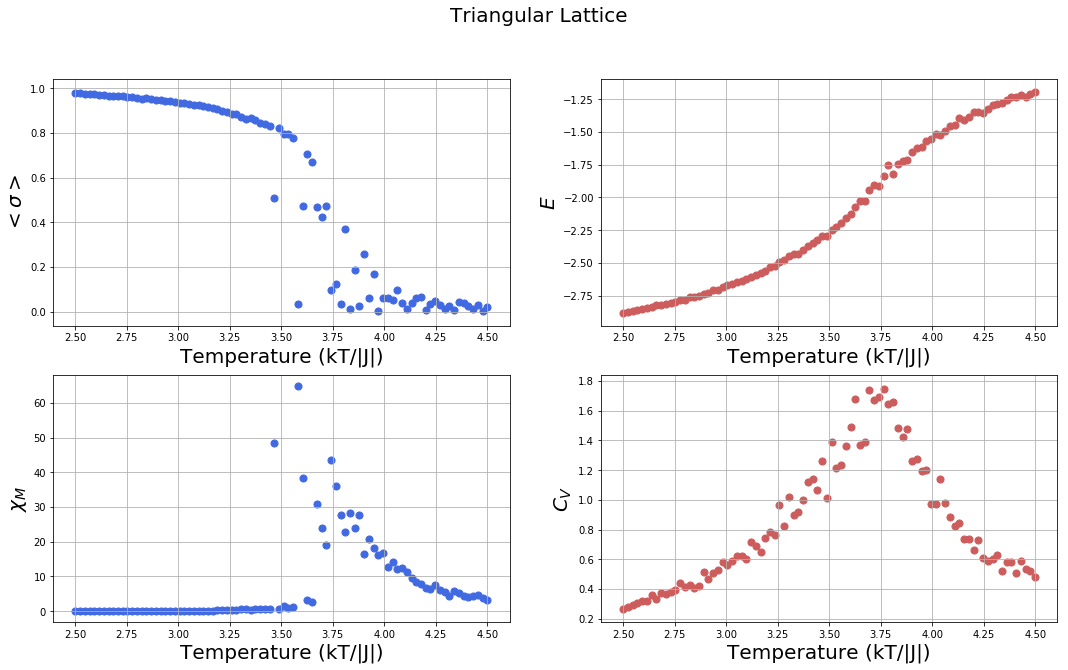

In [204]:
# Triangular Lattice
f = plt.figure(figsize=(18, 10)); # plot the calculated values   
    
sp = f.add_subplot(2,2,1);
plt.scatter(T, abs(Mag[:,0]), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (kT/|J|)", fontsize=20); 
plt.ylabel(r'$<\sigma>$', fontsize=20); 
plt.axis('tight'); plt.grid(True);
    
sp = f.add_subplot(2,2,2);
plt.scatter(T, Energy[:,0], s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (kT/|J|)", fontsize=20); 
plt.ylabel(r'$E$', fontsize=20); 
plt.axis('tight'); plt.grid(True);
    
sp = f.add_subplot(2,2,4);
plt.scatter(T, Cv[:,0], s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (kT/|J|)", fontsize=20); 
plt.ylabel(r'$C_V$', fontsize=20); 
plt.axis('tight'); plt.grid(True);
    
sp = f.add_subplot(2,2,3);
plt.scatter(T, ChiX[:,0], s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (kT/|J|)", fontsize=20); 
plt.ylabel(r'$\chi_M$', fontsize=20); 
plt.axis('tight'); plt.grid(True);
    
f.suptitle('Triangular Lattice',fontsize=20)


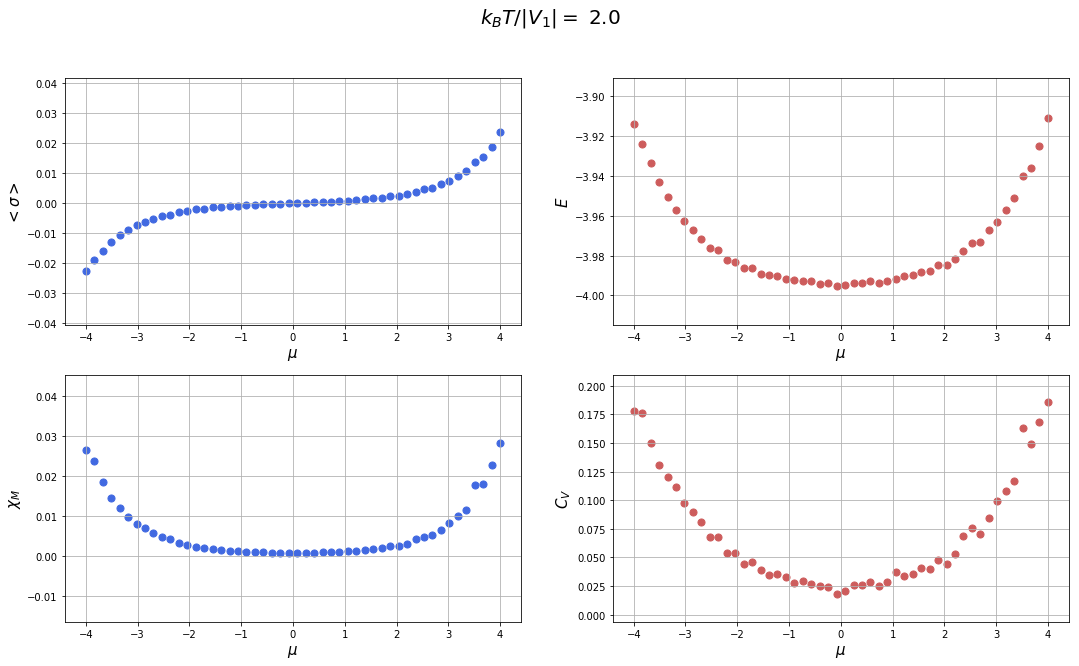

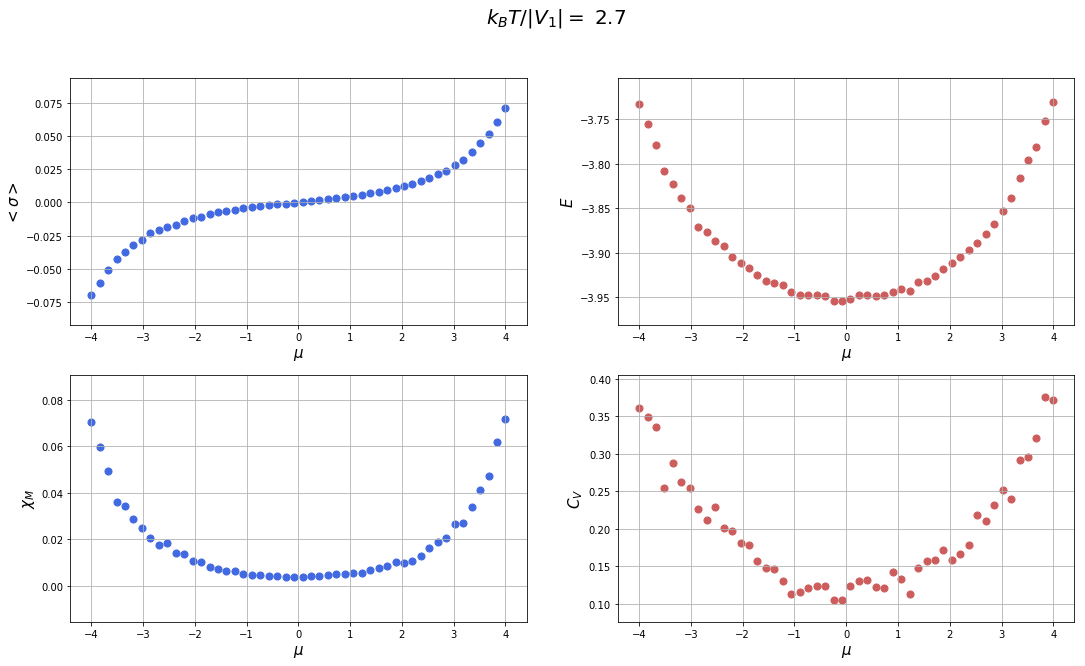

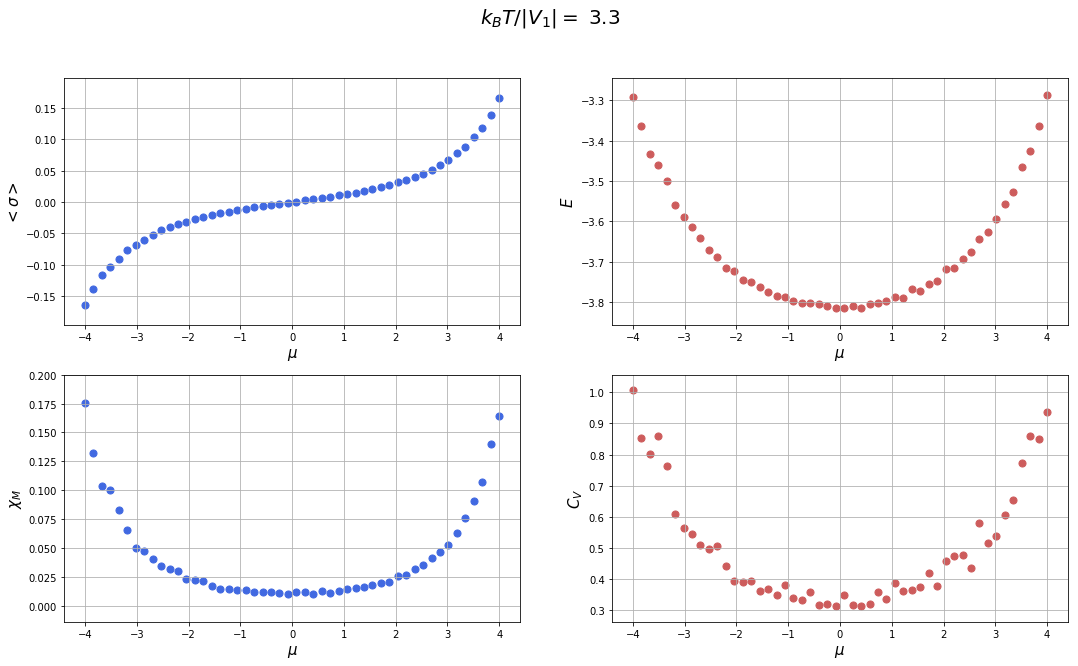

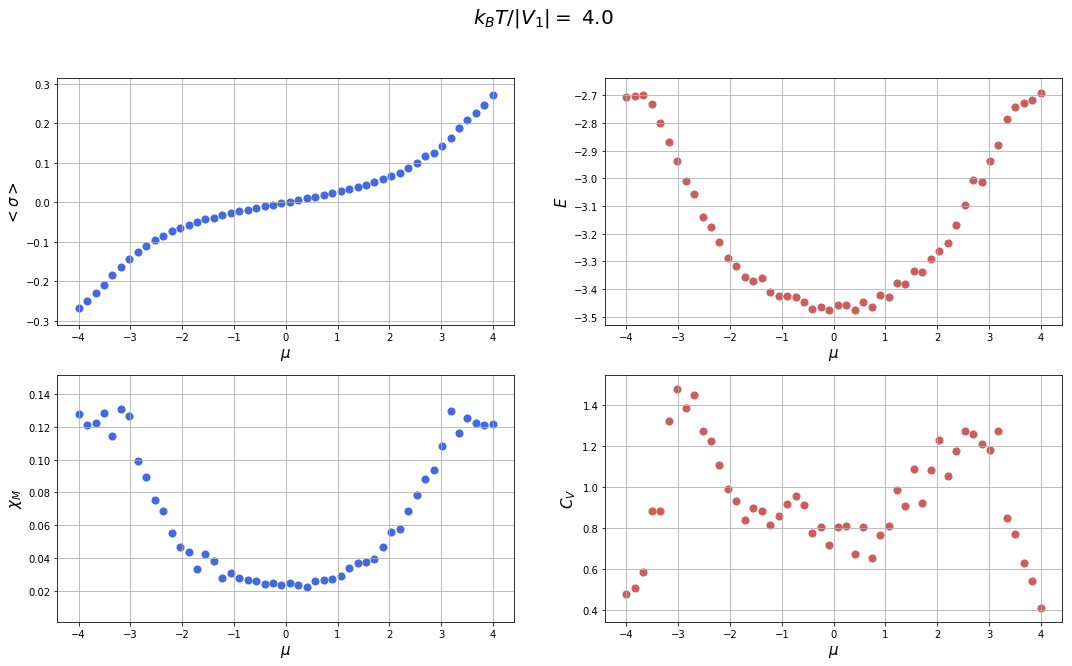

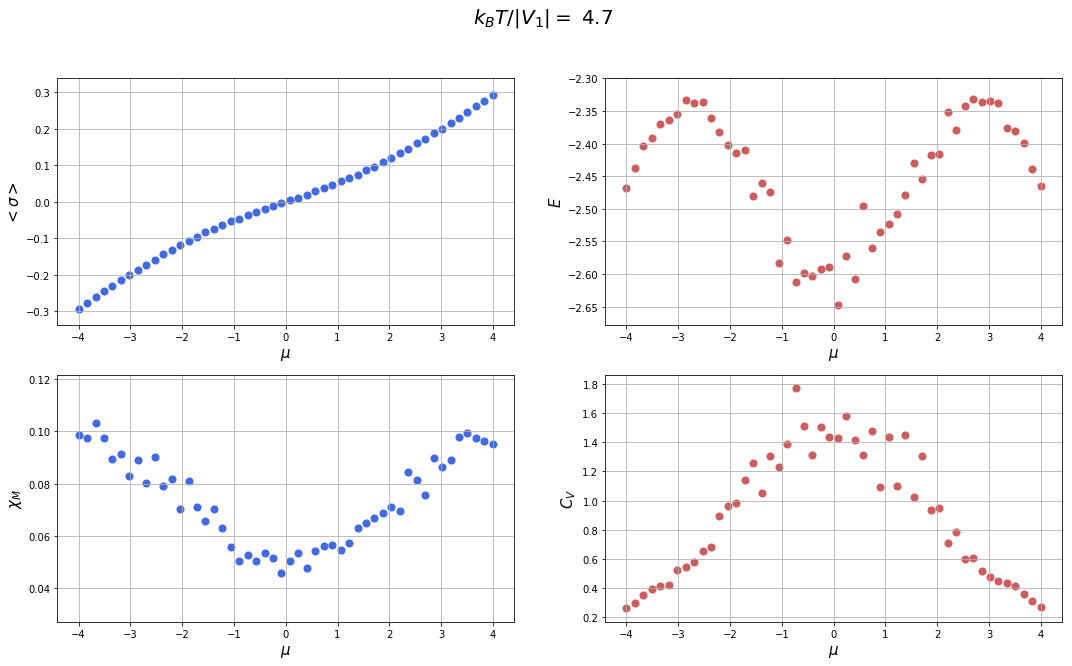

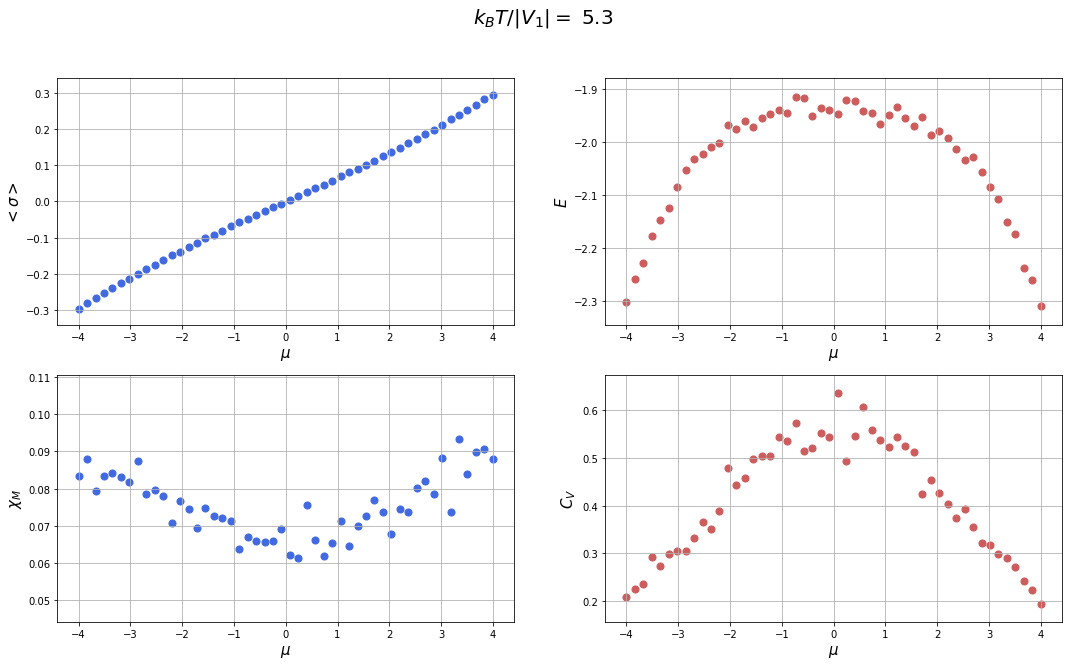

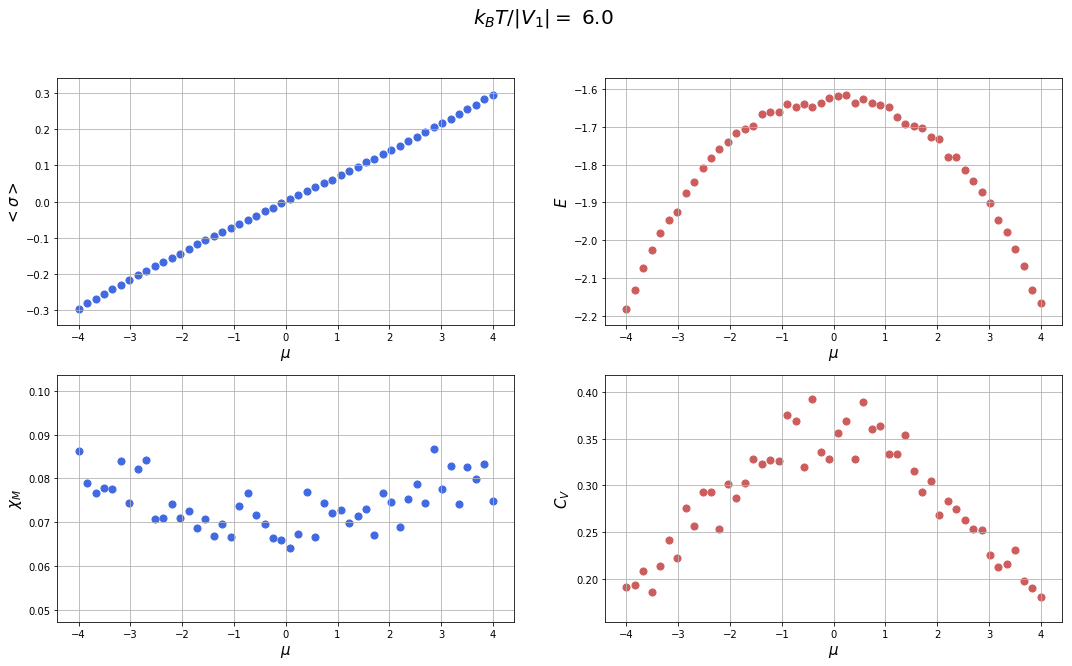

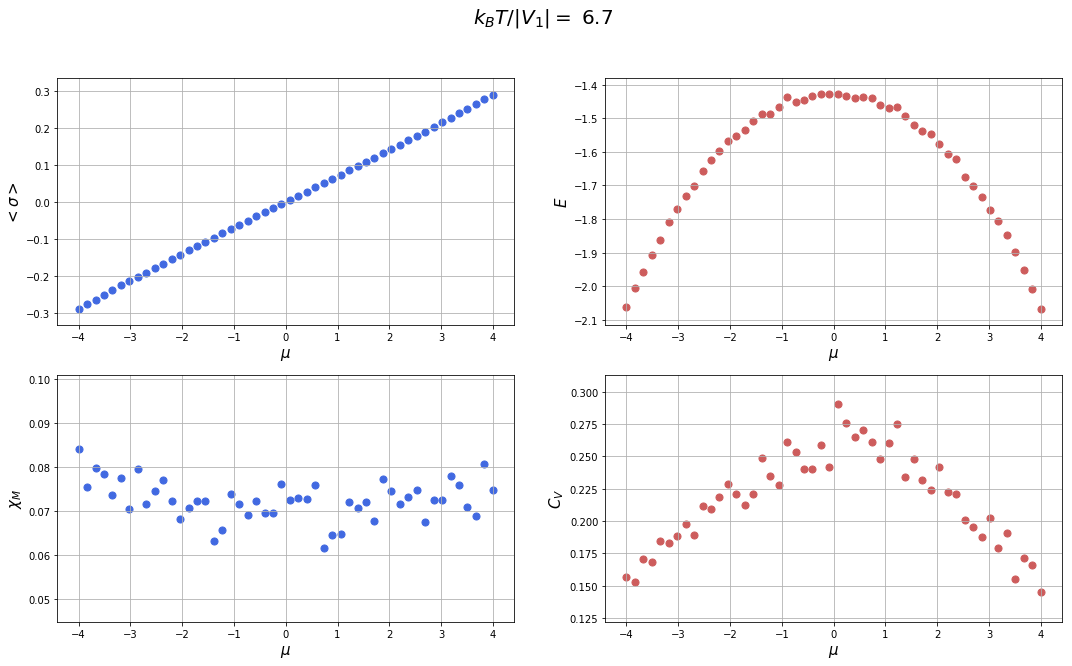

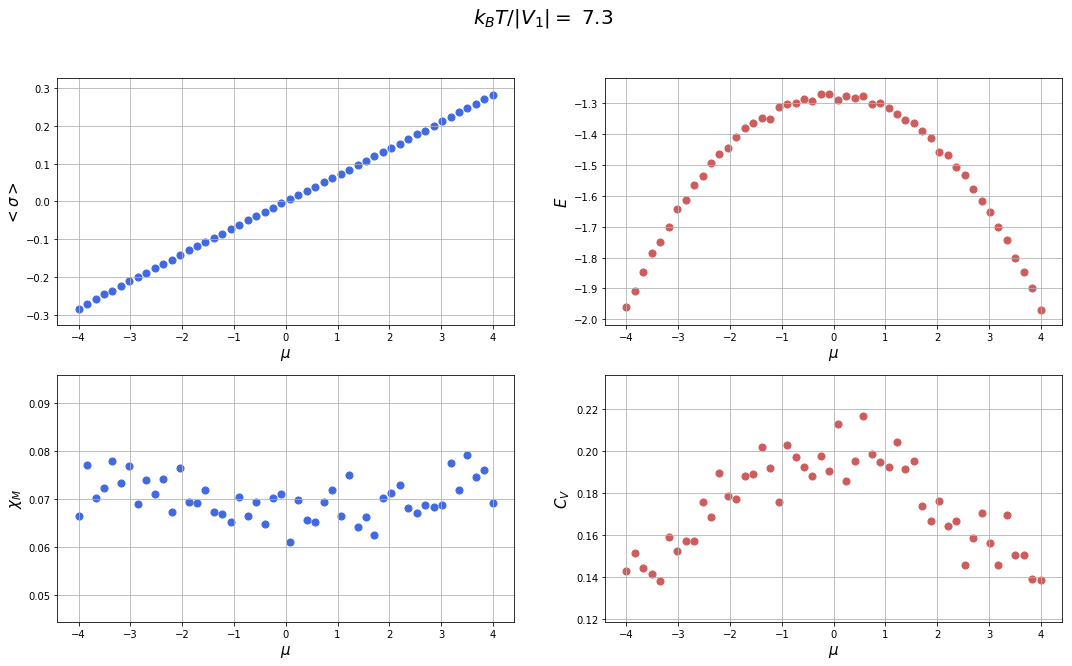

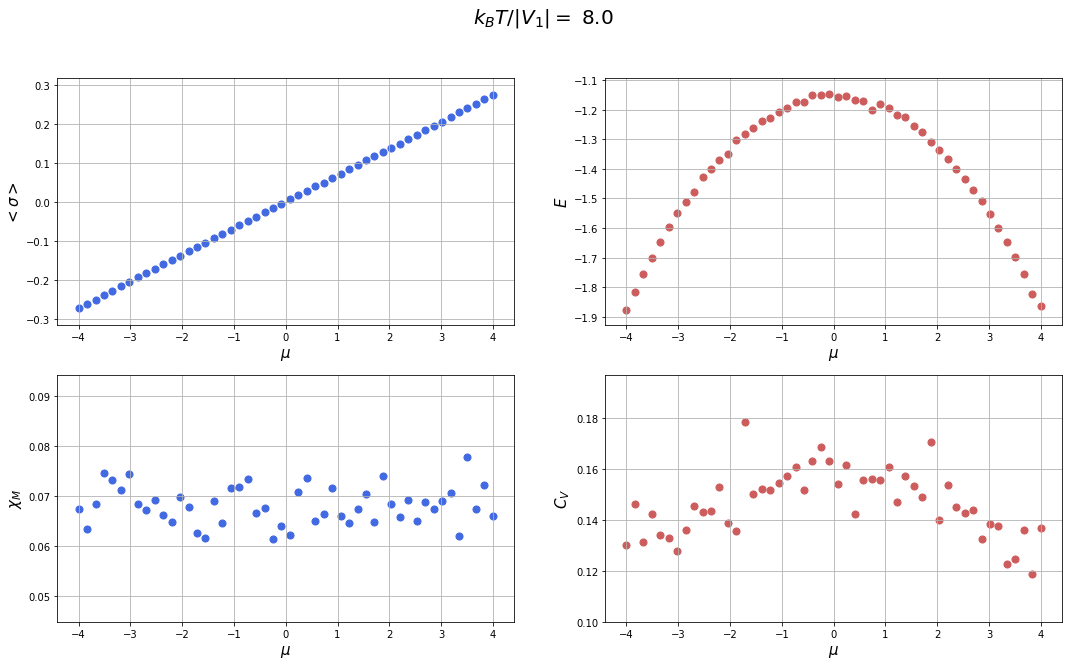

In [184]:
# H/Pd(100) phase diagram with V1 = -1, V2 = 2 (flipped interaction signs)
for i in range(len(T)): 
    f = plt.figure(figsize=(18, 10)); # plot the calculated values   
    
    sp = f.add_subplot(2,2,1);
    plt.scatter(mu, Mag[i,:], s=50, marker='o', color='RoyalBlue')
    plt.xlabel(r'$\mu$',fontsize=15)
    plt.ylabel(r'$<\sigma>$', fontsize=15); 
    plt.axis('tight'); plt.grid(True);
    
    sp = f.add_subplot(2,2,2);
    plt.scatter(mu, Energy[i,:], s=50, marker='o', color='IndianRed')
    plt.xlabel(r'$\mu$',fontsize=15)
    plt.ylabel(r'$E$', fontsize=15); 
    plt.axis('tight'); plt.grid(True);
    
    sp = f.add_subplot(2,2,4);
    plt.scatter(mu, Cv[i,:], s=50, marker='o', color='IndianRed')
    plt.xlabel(r'$\mu$',fontsize=15)
    plt.ylabel(r'$C_V$', fontsize=15); 
    plt.axis('tight'); plt.grid(True);
    
    sp = f.add_subplot(2,2,3);
    plt.scatter(mu, ChiX[i,:], s=50, marker='o', color='RoyalBlue')
    plt.xlabel(r'$\mu$',fontsize=15)
    plt.ylabel(r'$\chi_M$', fontsize=15); 
    plt.axis('tight'); plt.grid(True);
    
    f.suptitle(r'$k_BT/|V_1| =$ %0.1f' %(T[i]),fontsize=20)
    plt.pause(0.1)


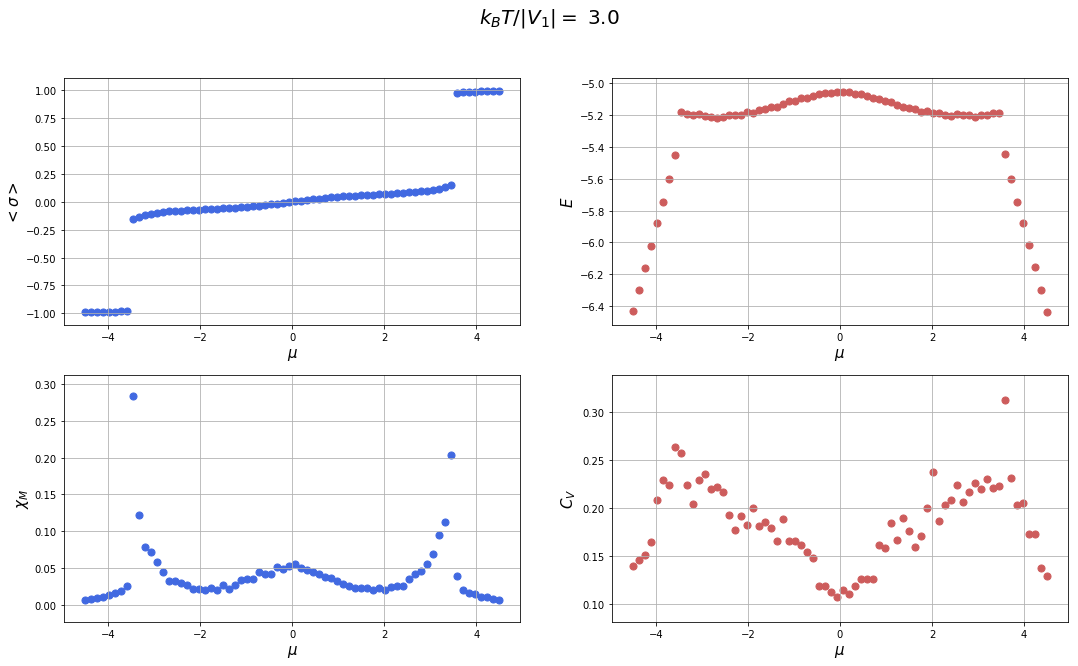

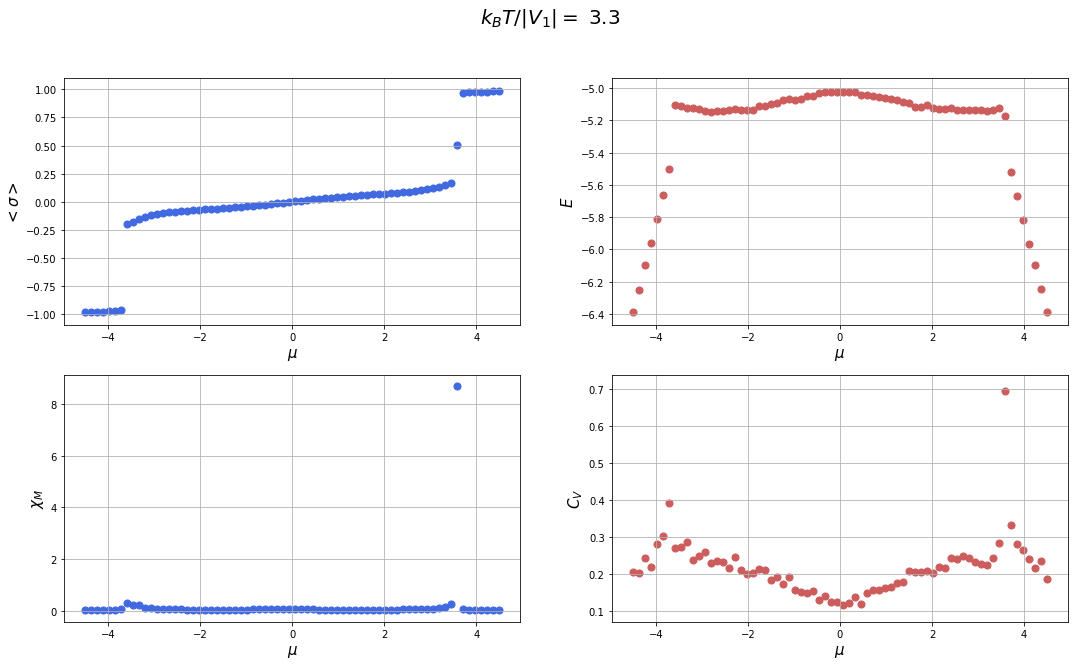

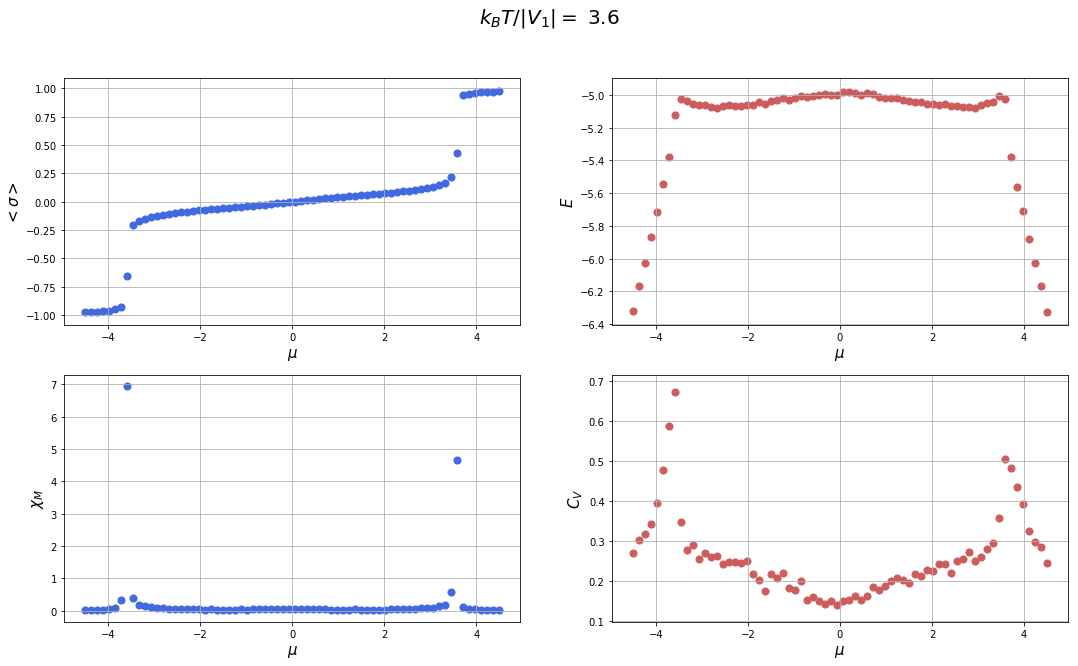

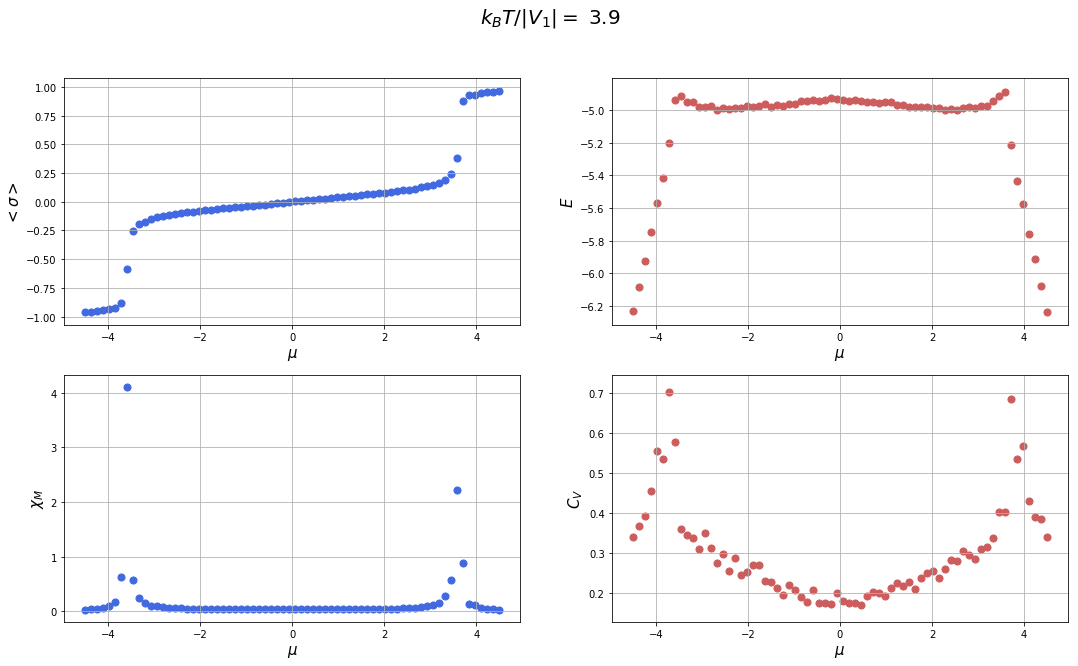

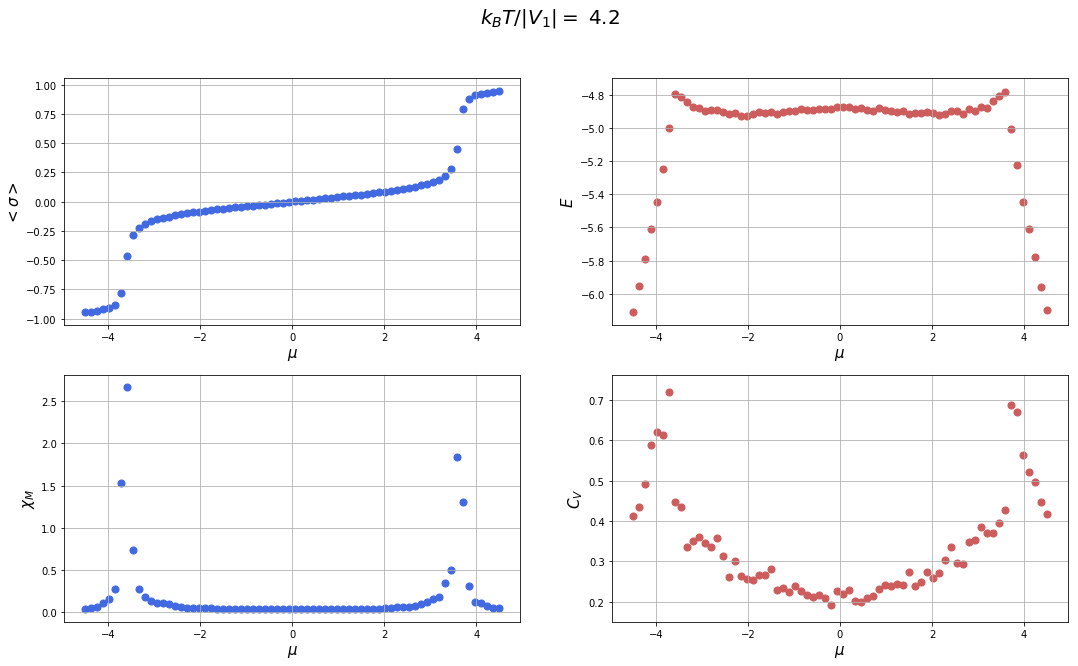

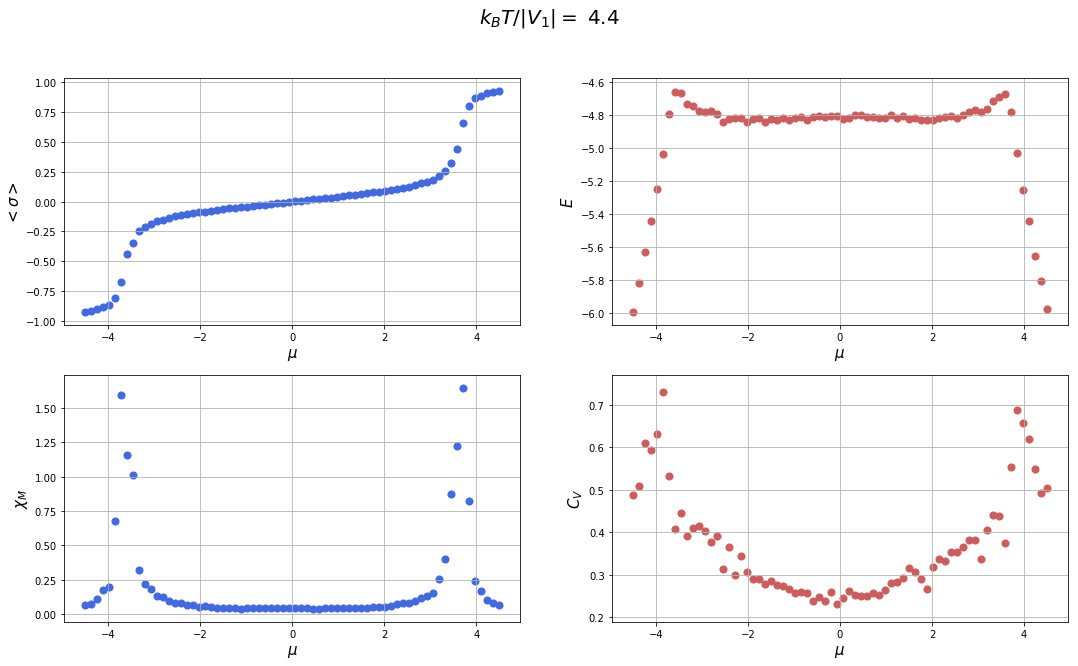

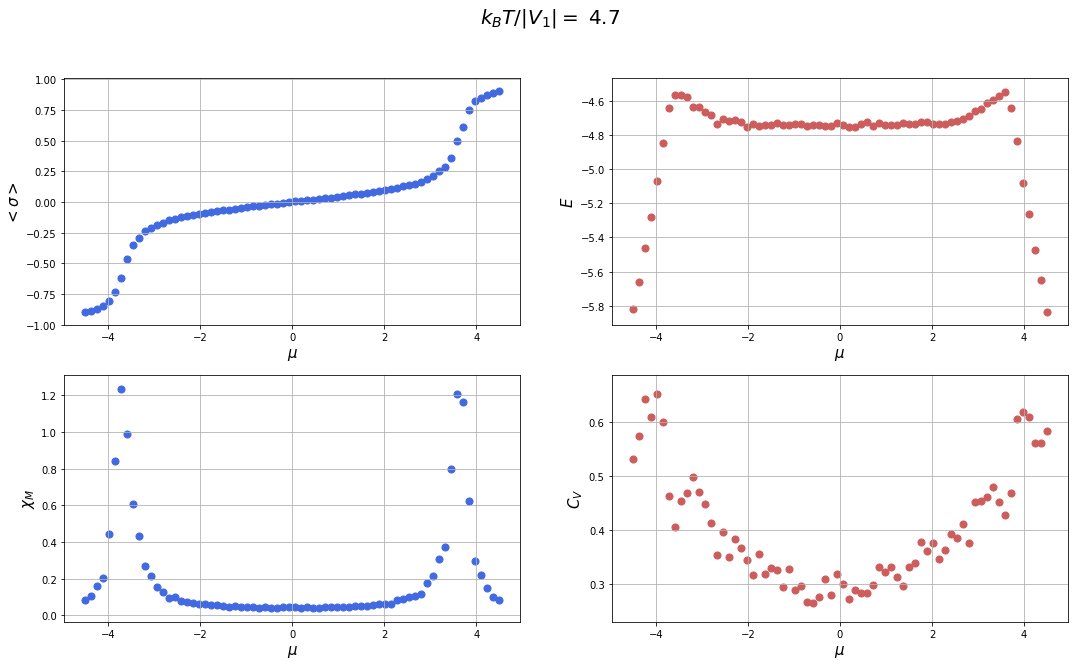

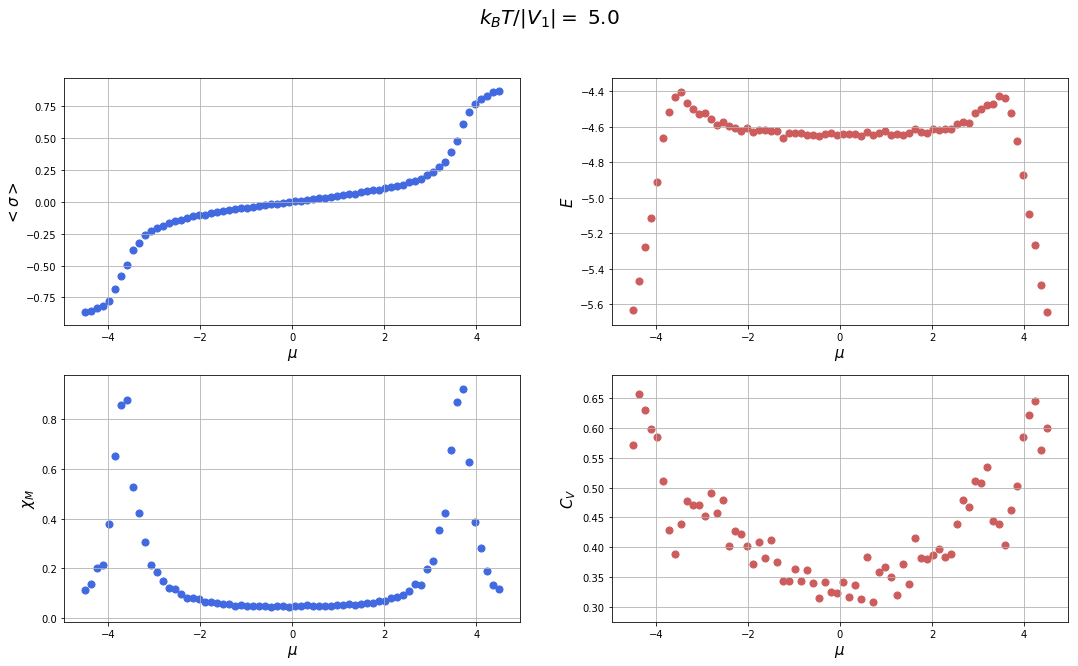

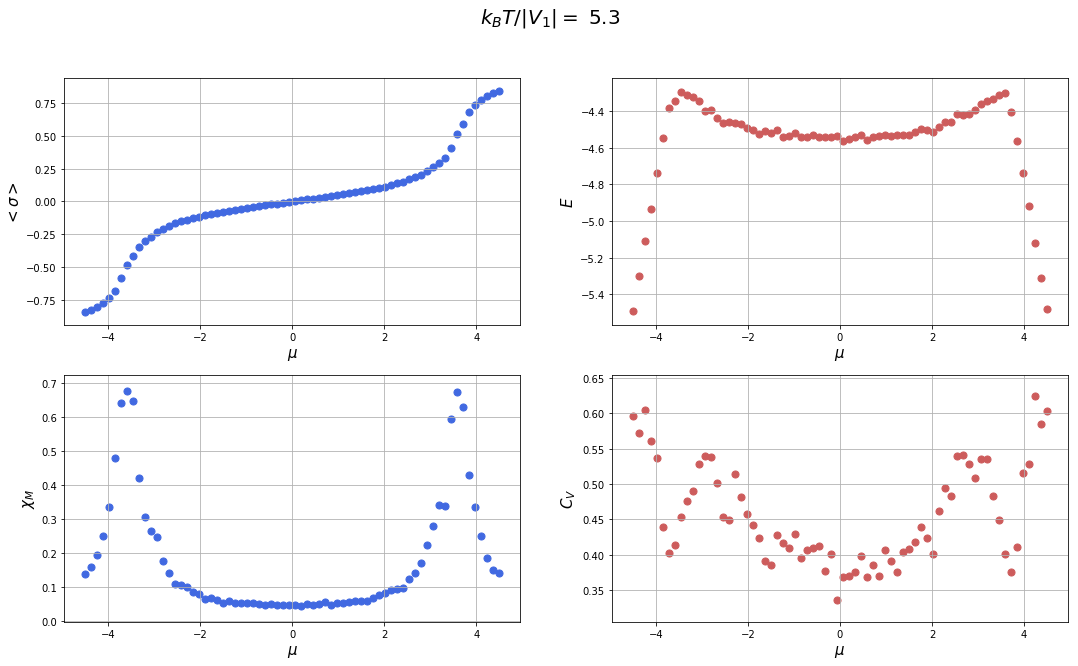

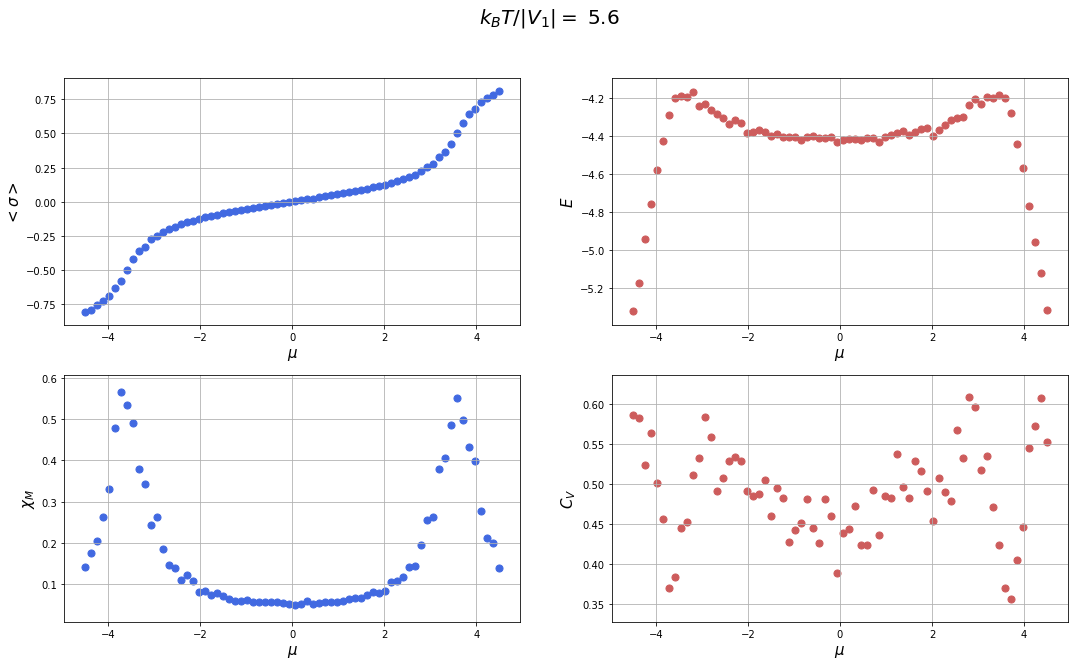

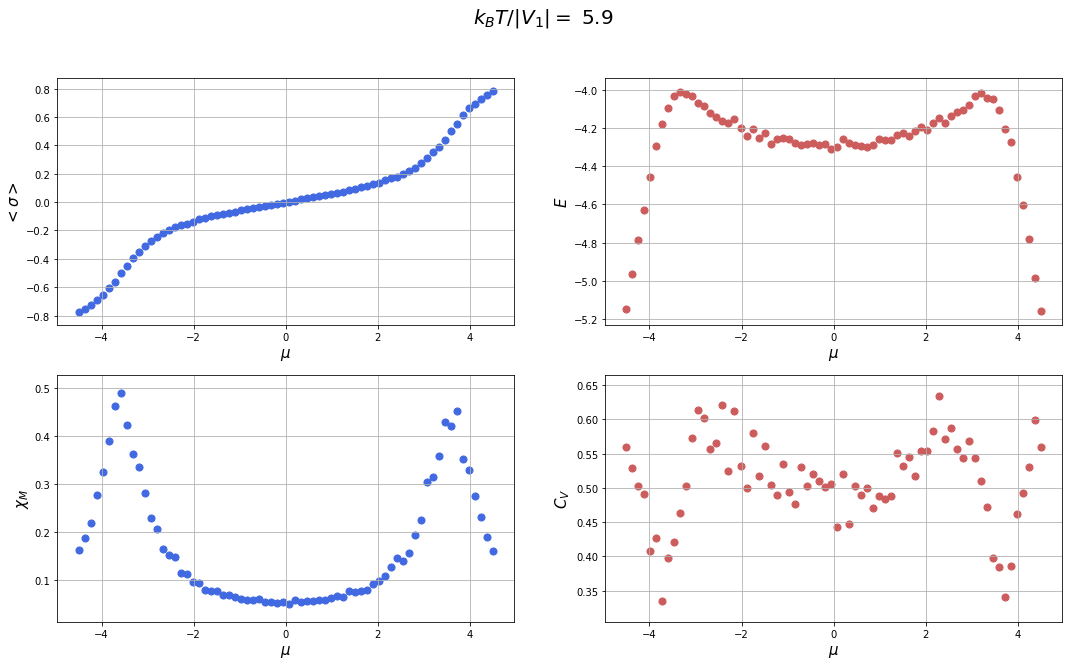

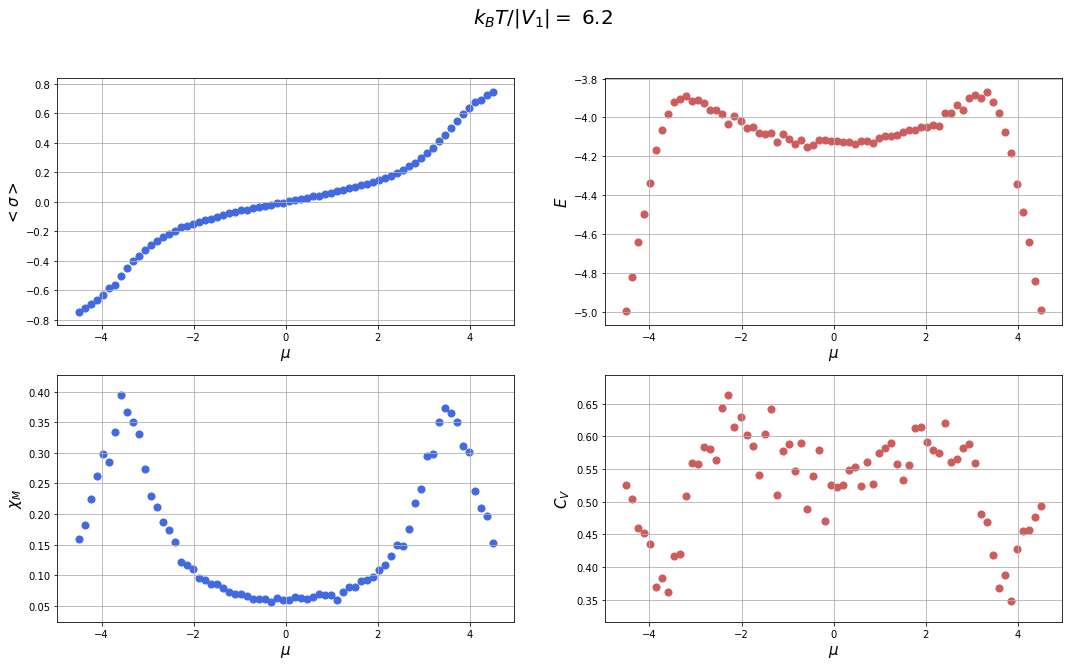

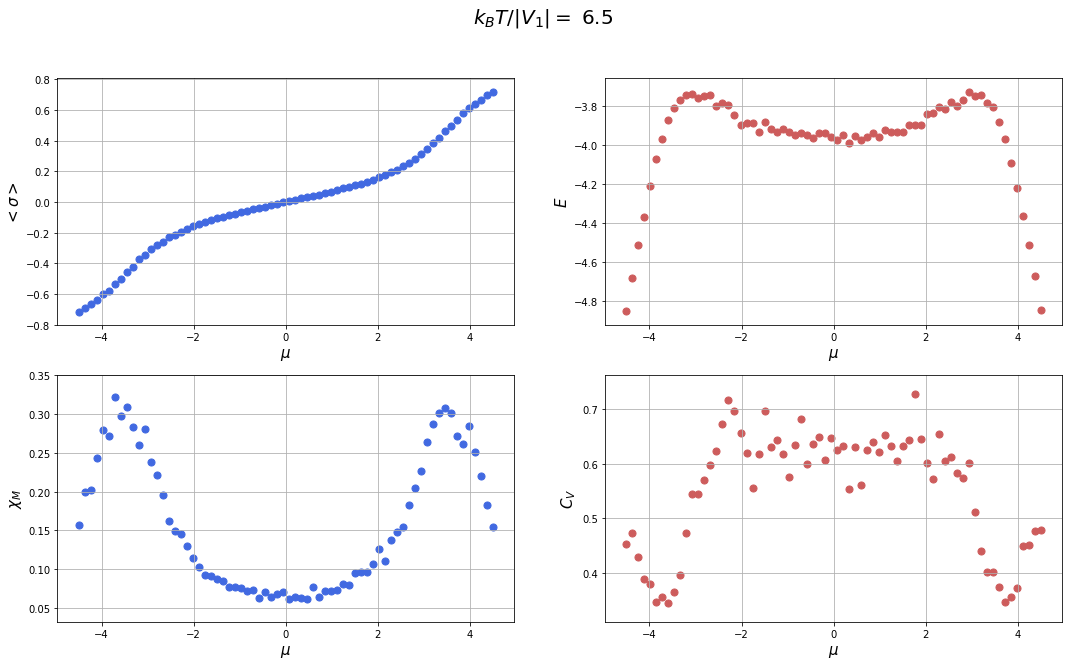

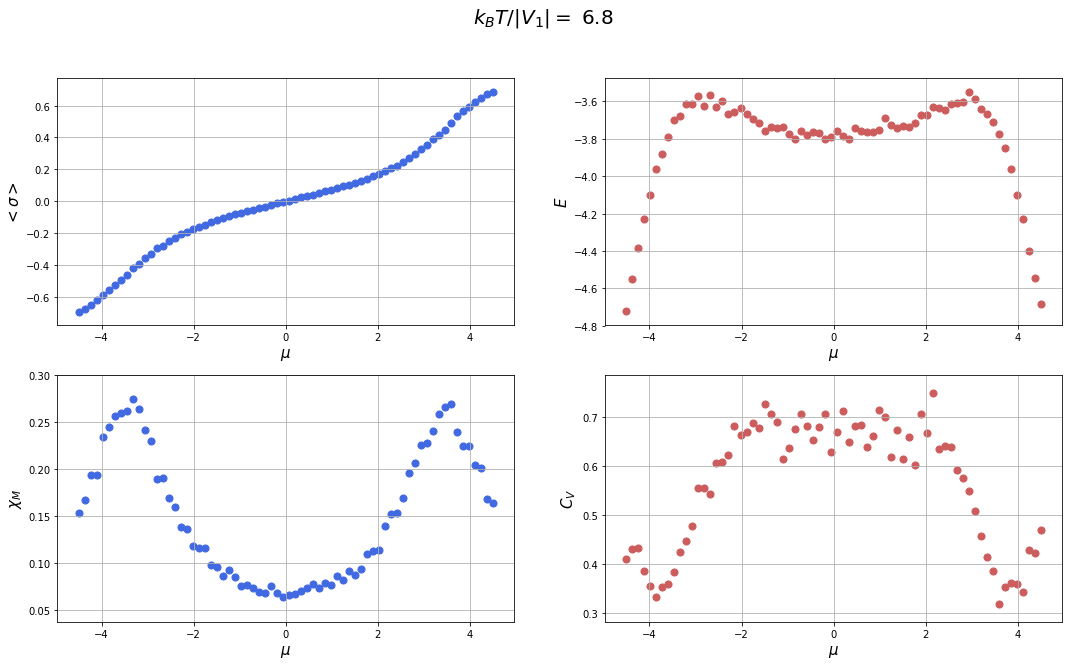

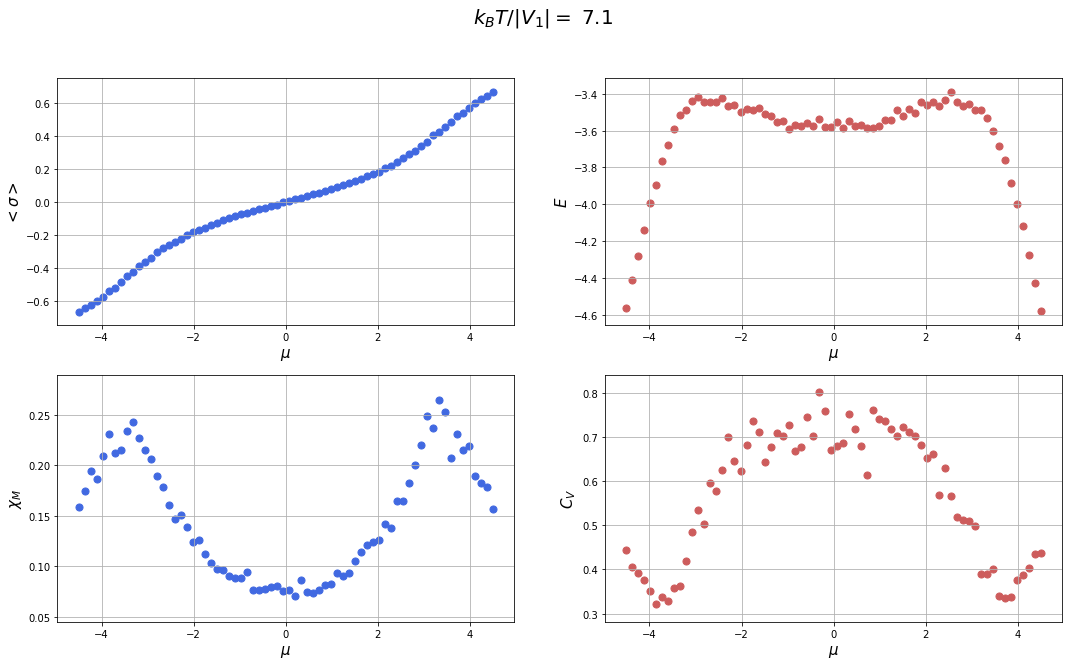

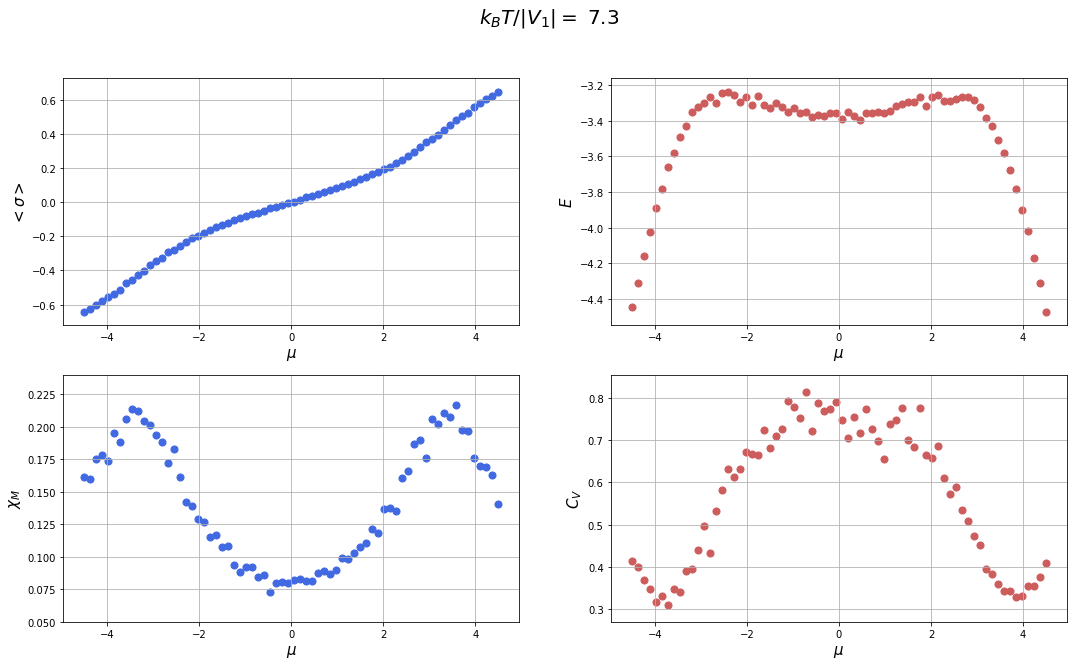

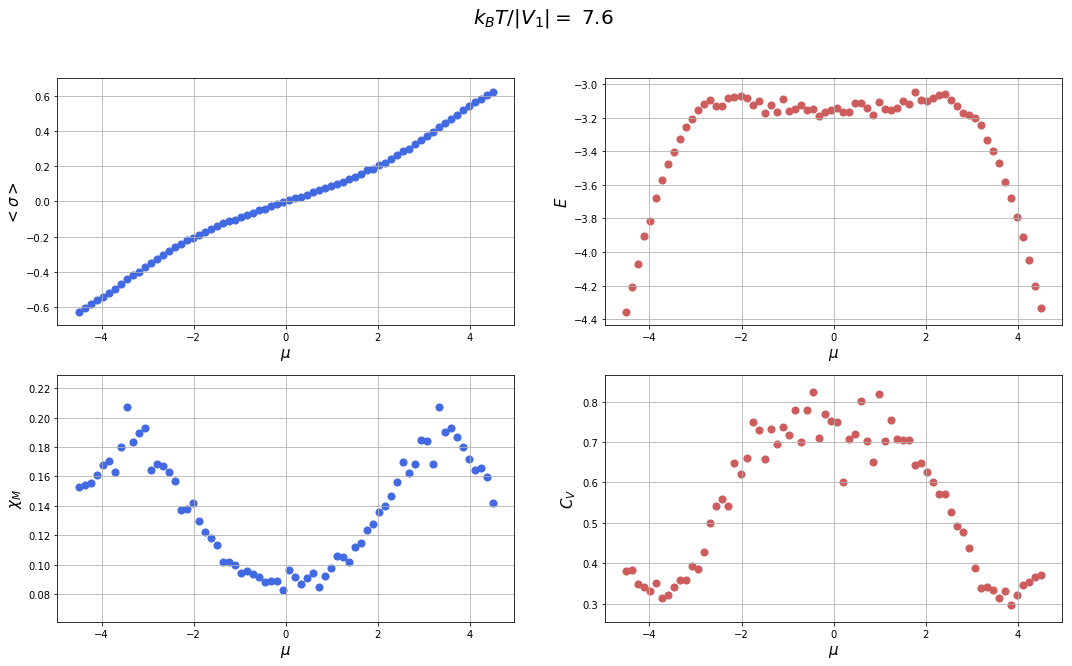

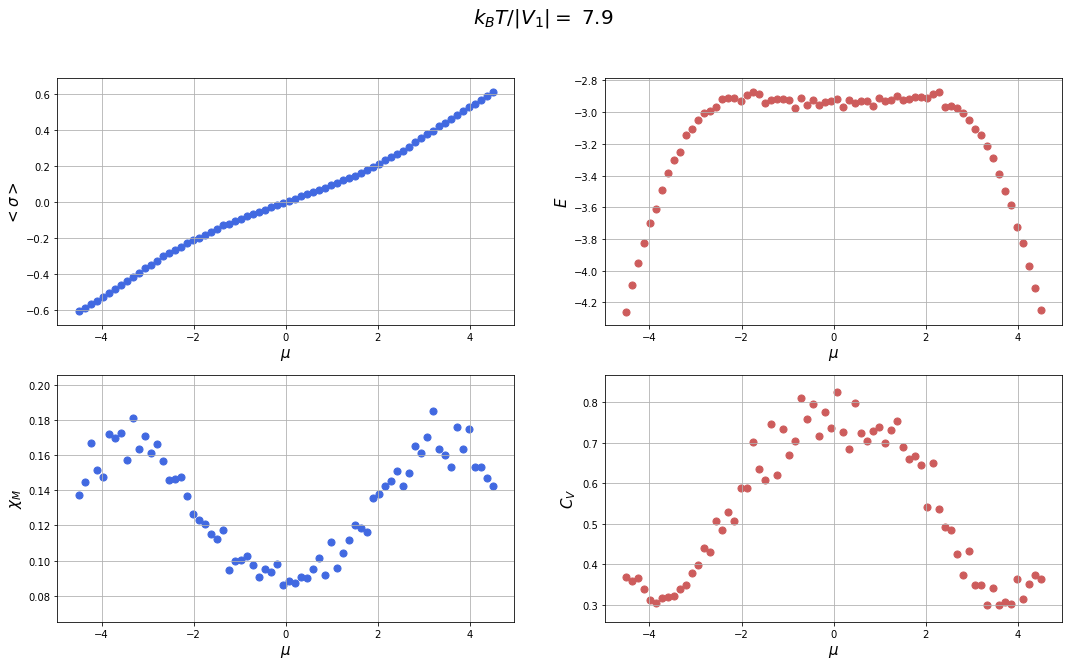

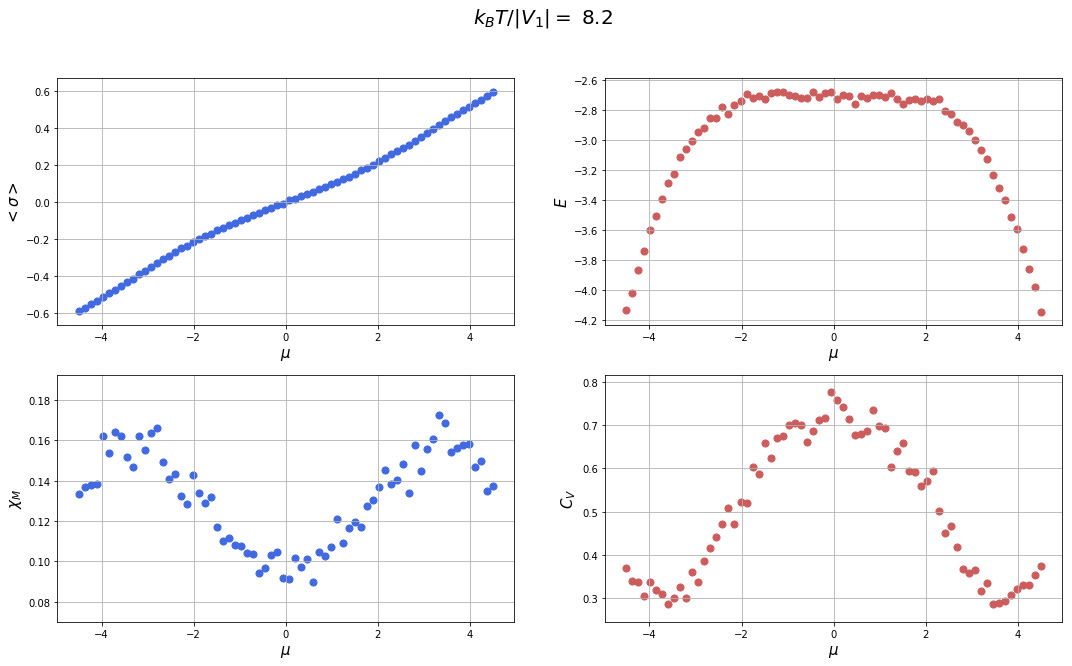

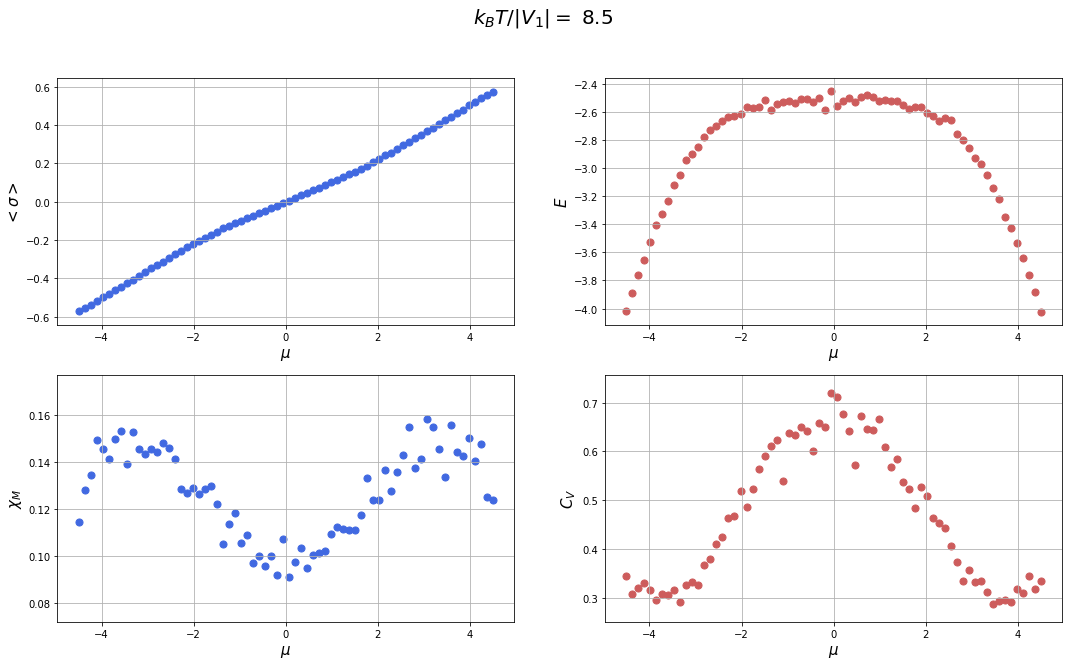

In [9]:
# H/Pd(100) Adsorption Phase Diagram
for i in range(len(T)): 
    f = plt.figure(figsize=(18, 10)); # plot the calculated values   
    
    sp = f.add_subplot(2,2,1);
    plt.scatter(mu, Mag[i,:], s=50, marker='o', color='RoyalBlue')
    plt.xlabel(r'$\mu$',fontsize=15)
    plt.ylabel(r'$<\sigma>$', fontsize=15); 
    plt.axis('tight'); plt.grid(True);
    
    sp = f.add_subplot(2,2,2);
    plt.scatter(mu, Energy[i,:], s=50, marker='o', color='IndianRed')
    plt.xlabel(r'$\mu$',fontsize=15)
    plt.ylabel(r'$E$', fontsize=15); 
    plt.axis('tight'); plt.grid(True);
    
    sp = f.add_subplot(2,2,4);
    plt.scatter(mu, Cv[i,:], s=50, marker='o', color='IndianRed')
    plt.xlabel(r'$\mu$',fontsize=15)
    plt.ylabel(r'$C_V$', fontsize=15); 
    plt.axis('tight'); plt.grid(True);
    
    sp = f.add_subplot(2,2,3);
    plt.scatter(mu, ChiX[i,:], s=50, marker='o', color='RoyalBlue')
    plt.xlabel(r'$\mu$',fontsize=15)
    plt.ylabel(r'$\chi_M$', fontsize=15); 
    plt.axis('tight'); plt.grid(True);
    
    f.suptitle(r'$k_BT/|V_1| =$ %0.1f' %(T[i]),fontsize=20)
    plt.pause(0.1)